# Vector embedding-based change detection -- flooding

In [ ]:
!mamba install -y -c conda-forge ffmpeg

---

In [1]:
import gc
from time import perf_counter

from rastervision.core.box import Box
from rastervision.core.data import (
    MinMaxTransformer, RasterioCRSTransformer, 
    StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.pipeline.file_system.utils import download_if_needed, json_to_file, file_to_json
from rastervision.core.data.utils import ensure_json_serializable
from rastervision.core import RasterStats
from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset)

import math
from tqdm.auto import tqdm, trange
import numpy as np
from shapely.geometry import mapping
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
import albumentations as A

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from matplotlib import animation
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

# Load data

In [2]:
embeddings_json = file_to_json('seasonal_variation_embeddings_tr_earthquake.json')
embeddings = np.array(embeddings_json['embeddings'])
t_strs = np.array(embeddings_json['t_strs'])
chips = None

In [3]:
chips = np.load('chips_tr_earthquake.npy')

In [4]:
mask = (t_strs != '2021-09-27')
embeddings = embeddings[mask]
t_strs = t_strs[mask]
if chips is not None:
    chips = chips[mask]
    assert len(chips) == len(embeddings)

In [5]:
inds_pre_2023 = np.where([s < '2023' for s in t_strs])[0]
inds_2023 = np.where([s.startswith('2023') for s in t_strs])[0]
inds_post_eq = np.where([s >= '2023-02-06' for s in t_strs])[0]

t_strs_pre_2023 = t_strs[inds_pre_2023]
embeddings_pre_2023 = embeddings[inds_pre_2023]

t_strs_2023 = t_strs[inds_2023]
embeddings_2023 = embeddings[inds_2023]

t_strs_post_eq = t_strs[inds_post_eq]
embeddings_post_eq = embeddings[inds_post_eq]

In [6]:
from datetime import datetime

t_doy = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs])
t_doy_pre_2023 = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_pre_2023])
t_doy_2023 = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_2023])
t_doy_post_eq = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_post_eq])

In [7]:
def to_t_day(t_str):
    t_tuple = datetime.strptime(t_str, '%Y-%m-%d').timetuple()
    return (t_tuple.tm_year + np.clip(t_tuple.tm_yday / 365, 0, 1))

In [8]:
t_day = np.array([to_t_day(t_str) for t_str in t_strs])
t_day_pre_2023 = np.array([to_t_day(t_str) for t_str in t_strs_pre_2023])
t_day_2023 = np.array([to_t_day(t_str) for t_str in t_strs_2023])
t_day_post_eq = np.array([to_t_day(t_str) for t_str in t_strs_post_eq])

In [9]:
mu = embeddings_pre_2023.mean(axis=0)
sigma = embeddings_pre_2023.std(axis=0)

In [10]:
z = np.clip(np.nan_to_num((embeddings - mu) / sigma), -6, 6)

---

# Animation

  0%|          | 0/270 [00:00<?, ?it/s]

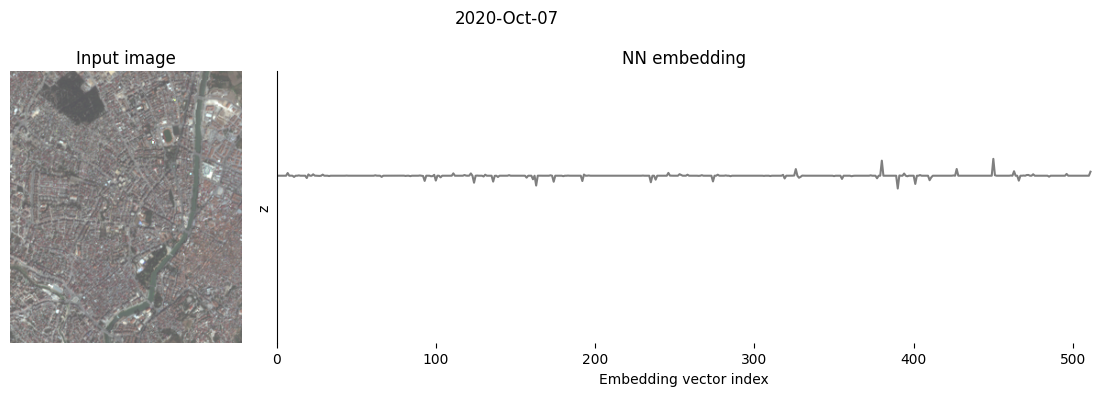

In [21]:
plt.close('all')
try: del fig
except: pass

trail_len = 5
_z_l2 = (embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True))
_z_l2 = _z_l2 - _z_l2.mean(axis=0)
fig, (ax_img, ax_emb) = plt.subplots(
    nrows=1, 
    ncols=2, 
    figsize=(12, 4), 
    squeeze=True,
    tight_layout=True,
    gridspec_kw=dict(
        width_ratios=[1, 2],
    ),
)

def data_gen():
    T = len(t_strs)
    with tqdm(range(T)) as bar:
        for i in bar:
            if i > 100:
                break
            bar.set_postfix_str(t_strs[i])
            yield i

artists_to_clear = []

def init():
    return [ax_img, ax_emb]


def run(data):
    i = data
    ax_img.clear()
    ax_img.axis('off')
    ax_img.imshow(chips[i])
    ax_emb.clear()
    inds = [i]
    for j in range(max(0, i - trail_len), i):
        inds.append(j)
    ax_emb.plot(_z_l2[inds].mean(axis=0), c='k', alpha=.5)
    fig.suptitle(datetime.strptime(t_strs[i], '%Y-%m-%d').strftime('%Y-%b-%d'))
    ax_img.set_title('Input image')
    ax_emb.set_title('NN embedding')
    ax_emb.set_xlim((0, 512))
    ax_emb.set_ylim((0.08, -0.05))
    ax_emb.set_yticks([], [])
    ax_emb.set_xlabel('Embedding vector index')
    ax_emb.set_ylabel('z')
    ax_emb.spines['top'].set_visible(False)
    ax_emb.spines['right'].set_visible(False)
    ax_emb.spines['bottom'].set_visible(False)
    # ax_emb.spines['left'].set_visible(False)
    return [ax_img, ax_emb]

anim = animation.FuncAnimation(fig, run, data_gen, init_func=init, interval=120)
anim.save('anim_embeddings_tr_earthquake.gif', savefig_kwargs=dict(transparent=False, facecolor='w'))

---

# PCA

In [11]:
from sklearn.decomposition import PCA, IncrementalPCA, FastICA, FactorAnalysis
from sklearn.linear_model import (
    LinearRegression, Ridge, BayesianRidge, HuberRegressor, RANSACRegressor,
    TheilSenRegressor, )

def t_to_feats(t):
    feat_1 = np.sin(t * np.pi * 2)
    feat_2 = np.cos(t * np.pi * 2)
    return np.stack([feat_1, feat_2], axis=1)

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [13]:
pca = PCA(whiten=True)
pca.fit(embeddings_pre_2023)
pc = 0

lr = RANSACRegressor()
Y = pca.transform(embeddings)[:, pc]
t = np.clip(t_doy / 365, 0, 1)
X = t_to_feats(t)
_ = lr.fit(X, Y)

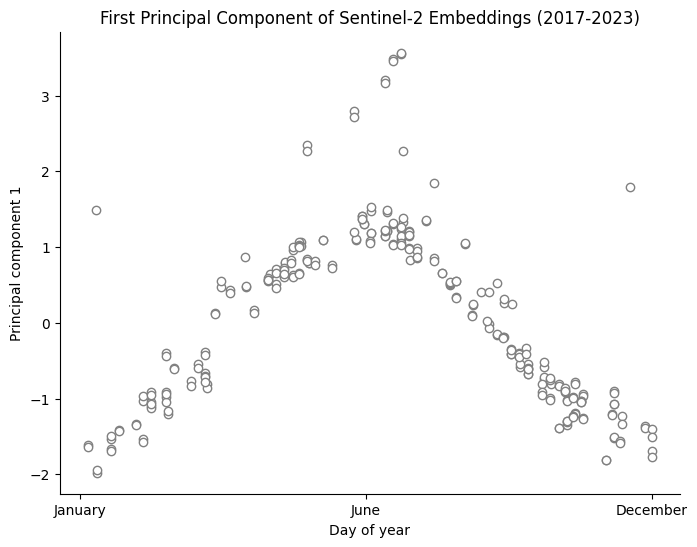

In [26]:
plt.close('all')
cmap = plt.get_cmap('Reds')
fig, ax = plt.subplots(1, 1, figsize=(8, 6), squeeze=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], fc='w', ec='gray', alpha=1)

# ax_ins = inset_axes(
#     ax, 1, 1, bbox_to_anchor=(0.6, 0.9), bbox_transform=ax.transAxes)
# ax_ins.imshow(chips[200])
# ax_ins.axis('off')


ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Day of year')
ax.set_ylabel('Principal component 1')
plt.show()

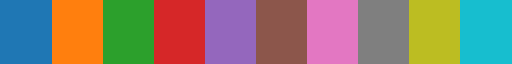

In [37]:
tab10 = plt.get_cmap('tab10')
tab10

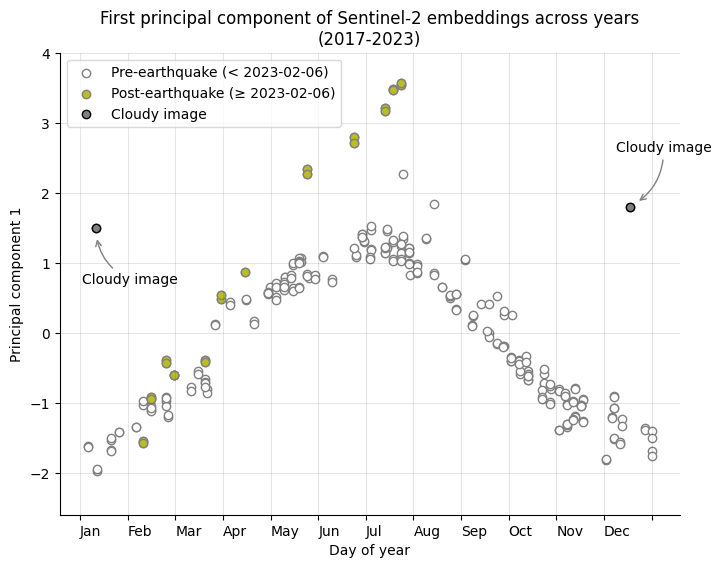

In [39]:
plt.close('all')
cmap = plt.get_cmap('Reds')
fig, ax = plt.subplots(1, 1, figsize=(8, 6), squeeze=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
# error = np.sqrt((lr.predict(t_to_feats(x)) - pca_emb[:, pc])**2)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
norm = Normalize(error.min(), error.max())
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c='w', ec='gray', alpha=1, label='Pre-earthquake (< 2023-02-06)')
ax.scatter(x[inds_post_eq], pca_emb[inds_post_eq, pc], c=tab10(8), ec='gray', alpha=1, label='Post-earthquake (≥ 2023-02-06)')
ax.scatter(x[[68, 242]], pca_emb[[68, 242], pc], c='gray', ec='k', alpha=1, label='Cloudy image')

ax.annotate('Cloudy image', 
            (x[68], pca_emb[68, pc]), 
            xycoords='data',
            xytext=(-10, 40),
            textcoords='offset points',
            arrowprops=dict(
                arrowstyle="->",
                connectionstyle=f'arc3,rad=-0.3',
                ec='gray',
                fc='w',
                shrinkB=8,
            ))
ax.annotate('Cloudy image', 
            (x[242], pca_emb[242, pc]), 
            xycoords='data',
            xytext=(-10, -40),
            textcoords='offset points',
            arrowprops=dict(
                arrowstyle="->",
                connectionstyle=f'arc3,rad=-0.3',
                ec='gray',
                fc='w',
                shrinkB=8,
            ))

ax.legend(loc='upper left', framealpha=0.75)
ax.grid('--', axis='both', c='k', alpha=0.1)
ax.set_xticks(np.arange(0, 13) / 12, 
              ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment('left')
ax.set_title('First principal component of Sentinel-2 embeddings across years\n(2017-2023)')
ax.set_xlabel('Day of year')
ax.set_ylabel('Principal component 1')
ax.set_ylim((-2.6, 4))
plt.show()

In [40]:
fig.savefig('pca_tr_earthquake.png', bbox_inches='tight', pad_inches=0.2)

---

# Regression

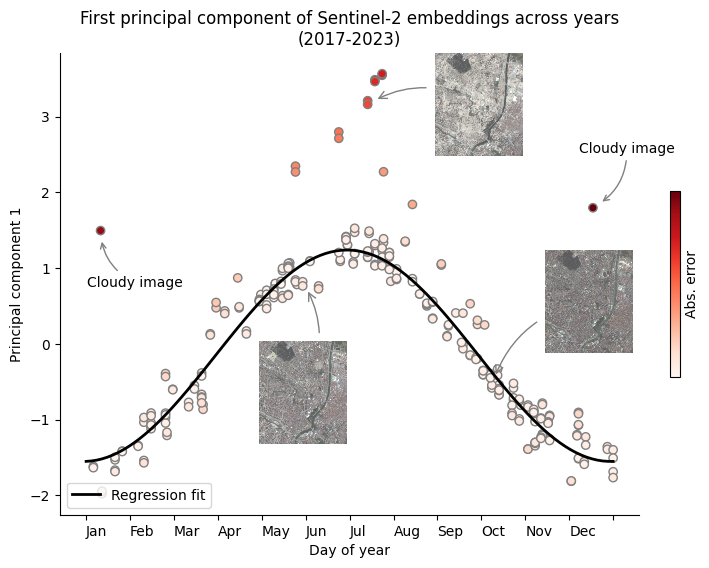

In [30]:
plt.close('all')
cmap = plt.get_cmap('Reds')
fig, ax = plt.subplots(1, 1, figsize=(8, 6), squeeze=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
# error = np.sqrt((lr.predict(t_to_feats(x)) - pca_emb[:, pc])**2)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
norm = Normalize(error.min(), error.max())
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)


img_inds = [100, 210, 265]
img_offsets = [(70, 60), (0, -80), (80, 0)]
arcs = [0.3] * len(img_inds)
for j, offset, arcrad in zip(img_inds, img_offsets, arcs):
    imagebox = OffsetImage(chips[j], zoom=0.25)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, (x[j], pca_emb[j, pc]),
                        xybox=offset,
                        xycoords='data',
                        boxcoords='offset points',
                        frameon=False,
                        arrowprops=dict(
                            arrowstyle="->",
                            shrinkB=8,
                            connectionstyle=f'arc3,rad={arcrad}',
                            ec='gray',
                        )
        )
    ax.add_artist(ab)

ax.annotate('Cloudy image', 
            (x[68], pca_emb[68, pc]), 
            xycoords='data',
            xytext=(-10, 40),
            textcoords='offset points',
            arrowprops=dict(
                arrowstyle="->",
                connectionstyle=f'arc3,rad=-0.3',
                ec='gray',
                fc='w',
                shrinkB=8,
            ))
ax.annotate('Cloudy image', 
            (x[242], pca_emb[242, pc]), 
            xycoords='data',
            xytext=(-10, -40),
            textcoords='offset points',
            arrowprops=dict(
                arrowstyle="->",
                connectionstyle=f'arc3,rad=-0.3',
                ec='gray',
                fc='w',
                shrinkB=8,
            ))

t = np.linspace(0, 1, 100)
x = t_to_feats(t)
y_pred = lr.predict(x)
ax.plot(t, y_pred, lw=2, c='k', label='Regression fit')
ax.legend(loc='lower left')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, fraction=0.015, ticks=[], label='Abs. error')

ax.set_xticks(np.arange(0, 13) / 12, 
              ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment('left')
ax.set_title('First principal component of Sentinel-2 embeddings across years\n(2017-2023)')
ax.set_xlabel('Day of year')
ax.set_ylabel('Principal component 1')
plt.show()

In [31]:
fig.savefig('pca_reg_tr_earthquake_err.png', bbox_inches='tight', pad_inches=0.2)

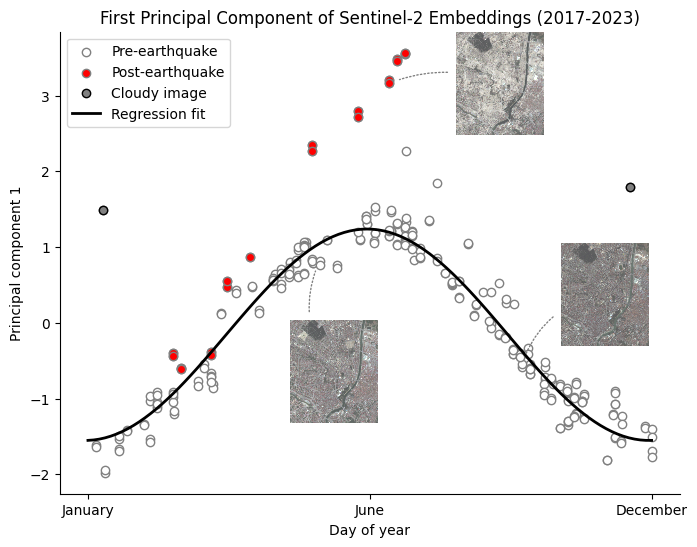

In [138]:
plt.close('all')
cmap = plt.get_cmap('Reds')
fig, ax = plt.subplots(1, 1, figsize=(8, 6), squeeze=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
# error = np.sqrt((lr.predict(t_to_feats(x)) - pca_emb[:, pc])**2)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
norm = Normalize(error.min(), error.max())
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c='w', ec='gray', alpha=1, label='Pre-earthquake')
ax.scatter(x[inds_post_eq], pca_emb[inds_post_eq, pc], c='r', ec='gray', alpha=1, label='Post-earthquake')
ax.scatter(x[[68, 242]], pca_emb[[68, 242], pc], c='gray', ec='k', alpha=1, label='Cloudy image')


img_inds = [100, 210, 265]
img_offsets = [(60, 50), (10, -80), (80, 0)]
arcs = [0.3, -0.3, 0.2]
for j, offset, arcrad in zip(img_inds, img_offsets, arcs):
    imagebox = OffsetImage(chips[j], zoom=0.25)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, (x[j], pca_emb[j, pc]),
                        xybox=offset,
                        xycoords='data',
                        boxcoords='offset points',
                        frameon=False,
                        arrowprops=dict(
                            arrowstyle="-",
                            shrinkB=8,
                            # connectionstyle="angle,angleA=0,angleB=90,rad=3",
                            connectionstyle=f'arc3,rad={arcrad}',
                            linestyle=':',
                            ec='gray',
                        )
        )
    ax.add_artist(ab)


t = np.linspace(0, 1, 100)
x = t_to_feats(t)
y_pred = lr.predict(x)
ax.plot(t, y_pred, lw=2, c='k', label='Regression fit')
ax.legend(loc='upper left')

ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Day of year')
ax.set_ylabel('Principal component 1')
# ax.set_ylim((-2.6, 4))
plt.show()

In [139]:
fig.savefig('pca_reg_tr_earthquake_img.png', bbox_inches='tight', pad_inches=0.2)

---

# Images

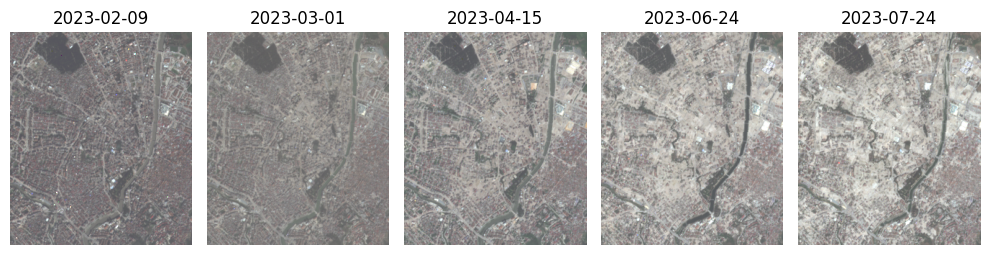

In [37]:
fig, axs = plt.subplots(1, 5, figsize=(10, 4), squeeze=True, tight_layout=True)
inds = [-22, -16, -11, -7, -1]
# inds = [-25, -22, -16, -11, -1]
for ax, idx in zip(axs, inds):
    ax.imshow(chips[idx])
    ax.set_title(t_strs[idx])
    ax.axis('off')
plt.show()

In [30]:
fig.savefig('tr_earthquake_img.png', bbox_inches='tight', pad_inches=0.)